In [1]:
import requests
import json

#import googlemaps
from itertools import tee

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap

In [2]:
London = gpd.read_file('./data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
commute_time=pd.read_csv('./data/travel_time_2011.csv')
commute_time_strike=pd.read_csv('./data/travel_time_without_metro_2011.csv')

In [3]:
London=London.to_crs(epsg=4326)
London_MSOA=London.loc[:,['MSOA11CD', 'MSOA11NM']]
London['centre']=London.to_crs('+proj=cea').centroid.to_crs(epsg=4326)
London['centre_lat'] = London.centre.apply(lambda p: p.y)
London['centre_lon'] = London.centre.apply(lambda p: p.x)
London

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,centre,centre_lat,centre_lon
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((-0.10414 51.50841, -0.10444 51...",POINT (-0.09213 51.51482),51.514821,-0.092128
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((0.14809 51.59678, 0.14806 51.59640, ...",POINT (0.13947 51.58827),51.588271,0.139475
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((0.15063 51.58306, 0.14838 51.58075, ...",POINT (0.14090 51.57492),51.574925,0.140897
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((0.18508 51.56480, 0.18400 51.56391, ...",POINT (0.17683 51.55548),51.555476,0.176828
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((0.14988 51.56807, 0.15076 51.56778, ...",POINT (0.14332 51.56142),51.561420,0.143324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.0,3338,2.5,"POLYGON ((0.02897 51.46779, 0.02993 51.46592, ...",POINT (0.02366 51.45811),51.458107,0.023656
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.0,2977,2.2,"MULTIPOLYGON (((-0.00964 51.48366, -0.00981 51...",POINT (-0.01841 51.48075),51.480748,-0.018408
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.4,3333,2.2,"POLYGON ((0.01616 51.49578, 0.01852 51.49498, ...",POINT (0.01164 51.49339),51.493389,0.011638
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.6,2876,2.3,"POLYGON ((0.00864 51.48917, 0.00834 51.48877, ...",POINT (0.01172 51.48618),51.486182,0.011718


In [4]:
commute_time=commute_time.rename(columns={'travel_time_p25':'commute_time_usual_p25',
                                         'travel_time_p50':'commute_time_usual_p50',
                                         'travel_time_p75':'commute_time_usual_p75'})
commute_time=commute_time.drop(['Unnamed: 0'], axis=1)
commute_time_strike=commute_time_strike.rename(columns={'travel_time_p25':'commute_time_strike_p25',
                                         'travel_time_p50':'commute_time_strike_p50',
                                         'travel_time_p75':'commute_time_strike_p75'})
commute_time_strike=commute_time_strike.drop(['Unnamed: 0'], axis=1)
commute_time_com = commute_time.merge(commute_time_strike, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
commute_time_com

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75
0,E02000001,City of London 001,E02000001,City of London 001,0,0.0,0.0,0,0.0,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,56,58.0,60.0,58,60.0,62.0
2,E02000213,Croydon 020,E02000001,City of London 001,49,51.0,53.0,53,55.0,57.0
3,E02000487,Havering 024,E02000001,City of London 001,60,63.0,67.0,61,64.0,68.0
4,E02000065,Bexley 001,E02000001,City of London 001,53,55.0,57.0,54,56.0,58.0
...,...,...,...,...,...,...,...,...,...,...
1018157,E02000952,Wandsworth 030,E02000364,Hackney 020,57,58.0,60.0,79,83.0,86.0
1018158,E02000275,Ealing 038,E02000364,Hackney 020,69,71.0,73.0,69,71.0,73.0
1018159,E02000978,Westminster 019,E02000364,Hackney 020,40,42.0,44.0,58,59.0,61.0
1018160,E02000436,Harrow 004,E02000364,Hackney 020,83,86.0,90.0,84,87.0,91.0


In [5]:
commute_time_com['commute_time_difference_p25']=commute_time_com['commute_time_strike_p25']-commute_time_com['commute_time_usual_p25']
commute_time_com['commute_time_difference_p50']=commute_time_com['commute_time_strike_p50']-commute_time_com['commute_time_usual_p50']
commute_time_com['commute_time_difference_p75']=commute_time_com['commute_time_strike_p75']-commute_time_com['commute_time_usual_p75']

commute_time_com.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
0,E02000001,City of London 001,E02000001,City of London 001,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,56,58.0,60.0,58,60.0,62.0,2,2.0,2.0
2,E02000213,Croydon 020,E02000001,City of London 001,49,51.0,53.0,53,55.0,57.0,4,4.0,4.0
3,E02000487,Havering 024,E02000001,City of London 001,60,63.0,67.0,61,64.0,68.0,1,1.0,1.0
4,E02000065,Bexley 001,E02000001,City of London 001,53,55.0,57.0,54,56.0,58.0,1,1.0,1.0


In [6]:
pd.set_option('display.float_format', '{:.6f}'.format)
commute_time_com.describe()

,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
count,1018162.000000,1014407.000000,1007696.000000,1018162.000000,989201.000000,957379.000000,1018162.000000,989127.000000,957253.000000
mean,66.062741,68.568094,70.870790,74.666911,76.861160,78.851863,8.604169,9.054270,9.471921
std,20.431107,20.868580,21.212512,23.072313,22.935254,22.747409,9.950194,10.193462,10.423393
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.000000,-24.000000,-24.000000
25%,52.000000,54.000000,56.000000,58.000000,61.000000,63.000000,0.000000,0.000000,0.000000
50%,66.000000,69.000000,71.000000,75.000000,78.000000,80.000000,5.000000,6.000000,6.000000
75%,81.000000,84.000000,86.000000,92.000000,95.000000,97.000000,14.000000,15.000000,15.000000
max,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,67.000000,65.000000,68.000000


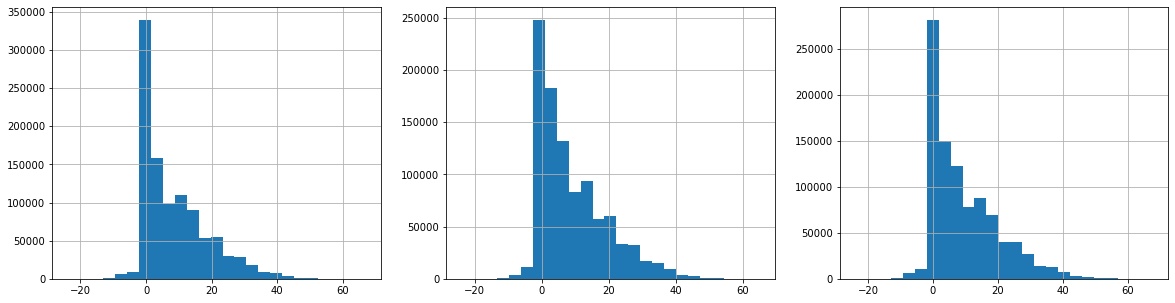

In [7]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3)
commute_time_com['commute_time_difference_p25'].hist(bins=25, ax=axes[0])
commute_time_com['commute_time_difference_p50'].hist(bins=25, ax=axes[1])
commute_time_com['commute_time_difference_p75'].hist(bins=25, ax=axes[2])
plt.show()

In [8]:
commute_time_strike_mean=commute_time_com.groupby(by='Origin_MSOACD').mean()
commute_time_strike_mean=commute_time_strike_mean.loc[:,['commute_time_difference_p25', 'commute_time_difference_p50', 'commute_time_difference_p75']]
commute_time_strike_mean=commute_time_strike_mean.reset_index()
commute_time_strike_des_mean=commute_time_com.groupby(by='Destination_MSOACD').mean()
commute_time_strike_des_mean=commute_time_strike_des_mean.loc[:,['commute_time_difference_p25', 'commute_time_difference_p50', 'commute_time_difference_p75']]
commute_time_strike_des_mean=commute_time_strike_des_mean.reset_index()
commute_time_strike_mean.head()

,Origin_MSOACD,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
0,E02000001,7.810247,8.413662,9.070342
1,E02000002,5.774044,5.221805,4.674731
2,E02000003,3.671672,3.965057,4.214210
3,E02000004,4.084352,4.053735,4.029619
4,E02000005,3.740933,3.968884,4.034949


<AxesSubplot:>

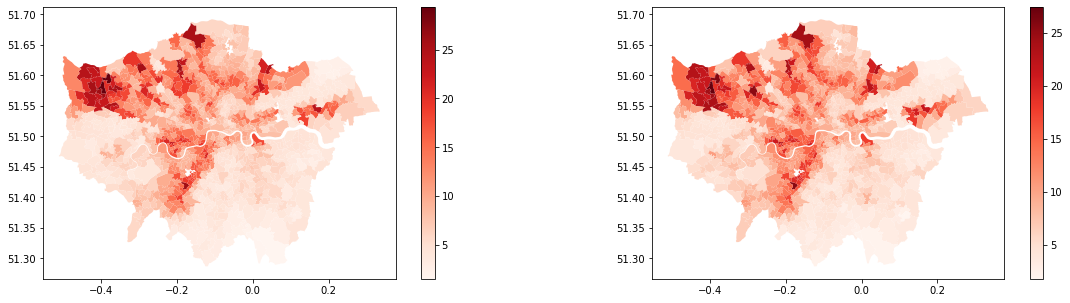

In [9]:
commute_time_strike_mean_geo=pd.merge(London, commute_time_strike_mean, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_strike_des_mean_geo=pd.merge(London, commute_time_strike_des_mean, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p50'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_mean_geo.plot(column=commute_time_strike_des_mean_geo['commute_time_difference_p50'], legend= True, cmap='Reds', ax=axes[1])